[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sapiosciences/sapio-py-tutorials/blob/master/2_manipulate_data_records.ipynb)

In [ ]:
import io

from sapiopylib.rest.AccessionService import AccessionDataFieldCriteriaPojo
from sapiopylib.rest.DataMgmtService import DataMgmtServer
from sapiopylib.rest.User import SapioUser
from sapiopylib.rest.pojo.DataRecord import DataRecord

user = SapioUser(url="https://linux-vm:8443/webservice/api",
                 guid="3c232543-f407-4828-aae5-b33d4cd31fa7", account_name="sapio",
                 username="pyRestTest", password="Password1!", verify_ssl_cert=False)
dataRecordManager = DataMgmtServer.get_data_record_manager(user)
accessionManager = DataMgmtServer.get_accession_manager(user)

# Editing Data Records
In this tutorial we will be creating new data records, set fields on records, add children to records, set and use attachment data.
As part of this, accession manager may be used to accession IDs for new data records the system is expecting.

In [ ]:
project_id_list = accessionManager.accession_for_field(2, AccessionDataFieldCriteriaPojo('Project', 'ProjectId', 'PyWebDemo'))
projects = dataRecordManager.add_data_records('Project', 2)

for project_id, project in zip(project_id_list, projects):
    project.set_field_value('ProjectId', project_id)
dataRecordManager.commit_data_records(projects)

', '.join(str(p) for p in projects)

/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


'Project 453, Project 454'

In the example above, we created two project records, accessioned their project IDs, and then saved the project IDs to these two projects.

**Note: in the real example, the accession key is important and must be consistent throughout all plugin/webservice/python logic for the same domain of IDs. See accession service guide for details.**

Now, let's create a sample record for each project, accession sample IDs for them, and then set a pig image to each child sample as record image.

**It's much faster when we reduce round trip time and use batch as much as possible.** (We have seen quite a few support tickets which were due to customer projects using non-batch methods and causing massive slowdown to the system.)

There is a method that let us create children for both and set fields to both directly. Let's use it!


In [ ]:
sample_accession_criteria = AccessionDataFieldCriteriaPojo('Sample', 'SampleId', 'PyWebDemo')
sample_accession_criteria.prefix = 'PyWebDemo-'
sample_id_list = accessionManager.accession_for_field(2, sample_accession_criteria)

project1 = projects[0]
project2 = projects[1]

sample1_field_map = {'SampleId': sample_id_list[0]}
sample2_field_map = {'SampleId': sample_id_list[1]}
parent_children_map = {
    project1: [sample1_field_map],
    project2: [sample2_field_map]
}
children_map = dataRecordManager.create_children_fields_for_parents('Sample', parent_children_map)

#DataRecord object has equality and hash implementation so that the same record type and record ID are equal.
#Therefore, we can do an equality check. sample1 will be first project's child, and sample2 will be second project's child.
#We created only 1 sample per project so we can random access its first element with [0] in the end.
sample1 = children_map.get(project1)[0]
sample2 = children_map.get(project2)[0]

#Time to set some pig images!
with open('resources/pig1.jpeg', 'rb') as pig_io:
    dataRecordManager.set_record_image(sample1, pig_io)

with open('resources/pig2.jpeg', 'rb') as pig_io:
    dataRecordManager.set_record_image(sample2, pig_io)

/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/

Let's display a pig right here in the notebook.
Sapio API is made for very large attachments. Therefore, when we receive the attachment we will be using streaming API.
We will have to define a function to consume stream in chunks. Each chunk is a small sub-array of the entire byte array of data.
(DO NOT DO THIS FOR LARGE FILES, SINCE MEMORY IS PRECIOUS. USE FILE SYSTEM BUFFER INSTEAD.)
The chunks will always be provided in sequence.

For the simplest implementation, we can just store the pig in memory, since we know already the image is quite small.

/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


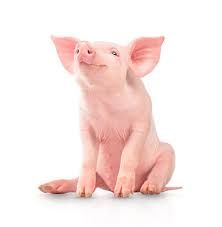

In [ ]:
from IPython.display import Image, display
from io import BytesIO

def consume_pig(chunk: bytes):
    pig_data.write(chunk)

with BytesIO() as pig_data:
    dataRecordManager.get_record_image(sample1, consume_pig)
    pig_data.flush()
    #Finished writing. Set current buffer cursor to initial position for reading operation.
    pig_data.seek(0)
    pig_bytes = pig_data.read()
    pig_data.close()
    pig_image = Image(pig_bytes, format="JPEG")
    display(pig_image)

Let's compare the pig with what's in the file.

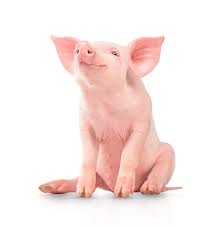

In [ ]:
from IPython.display import Image, display

with open('resources/pig1.jpeg', 'rb') as pig_io:
    pig_bytes = pig_io.read()
    pig_image = Image(pig_bytes, format="JPEG")
    display(pig_image)

# About Data Record Cache in Python
Data records keep track of the changed values and last saved values.
You can get the changed values and last saved values from each data record object.

These cache do not synchronize with server until you commit the records. If you obtain the same data record from server again through these API query calls in the previous tutorial, the local changes will not be there.

You can also roll back record changes individually with the *roll_back* method.

In [ ]:
plate: DataRecord = dataRecordManager.add_data_record("Plate")
plate.set_field_value("PlateId", "PyWeb-Test")
print("Current Field Map: " + str(plate.get_fields()))
print("Last Saved Plate ID: " + plate.get_last_saved_value("PlateId"))
print("Let's see what values have changed: " + str(plate.get_changed_fields_clone()))
print("Commit the record.")
dataRecordManager.commit_data_records([plate])
print("Current Field Map: " + str(plate.get_fields()))
print("Last Saved Plate ID: " + plate.get_last_saved_value("PlateId"))
print("Let's see what values have changed: " + str(plate.get_changed_fields_clone()))

/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Current Field Map: {'PlateSampleType': '', 'PlateWellCnt': 0, 'CreatedBy': 'pyRestTest', 'PlateColumns': 12, 'DateCreated': 1665151097754, 'PlateRows': 8, 'MultiParentLink176': None, 'MultiParentLink243': None, 'StorageUnitPath': '', 'RelatedRecord119': '', 'MultiParentLink146': None, 'ExemplarPlateStatus': '', 'DataRecordName': 'Plate 450', 'MultiParentLink181': None, 'RelatedRnaSamples': '', 'RowPosition': '', 'ColPosition': '', 'IsCircular': False, 'VeloxLastModifiedDate': 1665151097754, 'VeloxLastModifiedBy': 'pyRestTest', 'RelatedNotebookExperiment': '', 'PlateId': 'PyWeb-Test', 'RecordId': 450, 'StorageLocationBarcode': ''}
Last Saved Plate ID: 
Let's see what values have changed: {'PlateId': 'PyWeb-Test'}
Commit the record.
Current Field Map: {'PlateSampleType': '', 'PlateWellCnt': 0, 'CreatedBy': 'pyRestTest', 'PlateColumns': 12, 'DateCreated': 1665151097754, 'PlateRows': 8, 'MultiParentLink176': None, 'MultiParentLink243': None, 'StorageUnitPath': '', 'RelatedRecord119': '', '

# High Volume Data Types

While it is possible for you to create data records of high volume data types with the APIs we have shown you thus far, you might want to consider using dedicated APIs to insert records, especially when the volume of data is large (above 10,000 in a batch).

The advantage of using high-volume specific API to insert data, is that this will not create intermediate caching and data record control objects on the server and the data will directly be streamed to the database. It will not be participate in record caching and have no resident memory usage after API call has completed.

There are two methods to create HVDT records with data pump: *add_data_records_data_pump* method creates new records in ether, and *add_children_data_pump* method creates new records as children of parent records.

In [3]:
sample: DataRecord = dataRecordManager.query_system_for_record('Sample', 98)
sample_id: str = sample.get_field_value('SampleId')
row_pos: str = sample.get_field_value('RowPosition')
col_pos: str = sample.get_field_value('ColPosition')
pos: str = row_pos + col_pos
field_map_list = list()
for i in range(100):
    field_map = {
        'SampleId': sample_id,
        'DatumType': 'PythonTutorial',
        'QCStatus': 'Passed',
        'GeneExpressionValue': i,
        'RowPosition': row_pos,
        'ColPosition': col_pos,
        'Position': pos,
        'MapToSample': True
    }
    field_map_list.append(field_map)

#Assume in this simple case, all field map list data is for the same sample of object "sample" we queried.
new_record_id_list_map = dataRecordManager.add_children_data_pump('QCDatum', {sample: field_map_list})
new_record_id_list = new_record_id_list_map.get(sample)
print(','.join([str(x) for x in new_record_id_list]))

/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568
